# Imports

In [1]:
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


# Load and Prepare Dataset

In [2]:
train = pd.read_csv("/home/sanjana/Documents/DSML/Data sets/Mnist/mnist_train.csv")
test = pd.read_csv("/home/sanjana/Documents/DSML/Data sets/Mnist/mnist_test.csv")

In [3]:
train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print(train.shape, test.shape)

(60000, 785) (10000, 785)


In [5]:
train_x = np.asarray(train.iloc[:, 1:]).reshape(-1,28,28,1)
train_y = np.asarray(pd.get_dummies(train['label'], prefix='label'))
train_x.shape, train_y.shape

((60000, 28, 28, 1), (60000, 10))

In [6]:
test_x = np.asarray(test.iloc[:,1:]).reshape(-1,28,28,1)
test_y = np.asarray(pd.get_dummies(test['label'], prefix='label'))
test_x.shape, test_y.shape

((10000, 28, 28, 1), (10000, 10))

In [7]:
train_x = train_x/255
test_x = test_x/255

# Visualize 

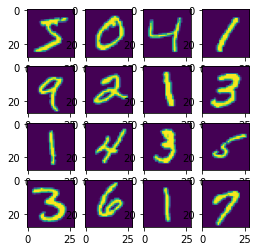

In [8]:
rows = 4
cols = 4
f = plt.figure(figsize=(rows,cols))
for i in range(rows*cols):
    f.add_subplot(rows,cols,i+1)
    plt.imshow(train_x[i].reshape([28,28]))

# Build Model using Tensorflow

In [9]:
tf.reset_default_graph()

In [10]:
def init_weights(shape):
    init_w = tf.truncated_normal(shape=shape, stddev=0.1)
    return tf.Variable(init_w)

In [11]:
def init_bias(shape):
    init_b = tf.constant(0.1, shape=shape)
    return tf.Variable(init_b)

In [12]:
def conv2d(x,W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding="SAME")

In [13]:
def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")

In [14]:
def convolutional_layer(x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(x,W)+b)

In [15]:
def fully_connected_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer,W)+b

In [16]:
def next_batch(j, batch_size):
    x = train_x[j:j+batch_size].reshape(50,28,28,1)
    y = train_y[j:j+batch_size]
    j = (j + batch_size) % len(train_x)
    return x, y,j

In [17]:
x = tf.placeholder(tf.float32, shape=[None,28,28,1])
y_true = tf.placeholder(tf.float32, shape=[None,10])

In [18]:
x_input = tf.reshape(x,[-1,28,28,1])

In [19]:
conv_1 = convolutional_layer(x_input, shape=[5,5,1,32])
conv_1_pool = max_pool_2by2(conv_1)

In [20]:
conv_2 = convolutional_layer(conv_1_pool, shape=[5,5,32,64])
conv_2_pool = max_pool_2by2(conv_2)

In [21]:
conv_2_flat = tf.reshape(conv_2_pool, shape=[-1,7*7*64])
fully_connected = tf.nn.relu(fully_connected_layer(conv_2_flat, 1024))

In [22]:
hold_prob = tf.placeholder(tf.float32)
fully_connected_dropout = tf.nn.dropout(fully_connected, hold_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [23]:
y_pred = fully_connected_layer(fully_connected_dropout,10)

In [24]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true, logits=y_pred))

In [25]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
train = optimizer.minimize(cross_entropy)

In [26]:
init = tf.global_variables_initializer()

In [27]:
steps = 5000
j = 0

with tf.Session() as sess:
    sess.run(init)
    for i in range(steps):
        batch_x, batch_y, j = next_batch(j, 50)
        sess.run(train, feed_dict={x:batch_x, y_true:batch_y, hold_prob:0.5})
        
        if i%100 == 0:
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
            acc = tf.reduce_mean(tf.cast(matches,tf.float32))
            print(sess.run(acc,feed_dict={x:test_x, y_true:test_y, hold_prob:1.0}))
            print('\n')


Currently on step 0
Accuracy is:
0.0943


Currently on step 100
Accuracy is:
0.862


Currently on step 200
Accuracy is:
0.9003


Currently on step 300
Accuracy is:
0.9298


Currently on step 400
Accuracy is:
0.9469


Currently on step 500
Accuracy is:
0.9526


Currently on step 600
Accuracy is:
0.9573


Currently on step 700
Accuracy is:
0.9612


Currently on step 800
Accuracy is:
0.9609


Currently on step 900
Accuracy is:
0.9637


Currently on step 1000
Accuracy is:
0.9649


Currently on step 1100
Accuracy is:
0.9695


Currently on step 1200
Accuracy is:
0.9675


Currently on step 1300
Accuracy is:
0.9727


Currently on step 1400
Accuracy is:
0.9723


Currently on step 1500
Accuracy is:
0.9753


Currently on step 1600
Accuracy is:
0.9755


Currently on step 1700
Accuracy is:
0.9766


Currently on step 1800
Accuracy is:
0.9763


Currently on step 1900
Accuracy is:
0.9757


Currently on step 2000
Accuracy is:
0.9758


Currently on step 2100
Accuracy is:
0.9768


Currently on step 2200
